In [1]:
import numpy as np
import os
from pathlib import Path

# Import Keras for implementing autoencoders
import keras
from keras.models import Sequential
from keras.layers import Input, Dense, LSTM

from keras.utils import plot_model

## Preprocessing

In [2]:
batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
# Path to the data txt file on disk.
# data_path = 'deu-eng/deu.txt'
data_path = 'fra-eng/fra.txt'

In [3]:
# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split("\t")
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = "\t" + target_text + "\n"
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)


Number of samples: 10000
Number of unique input tokens: 70
Number of unique output tokens: 91
Max sequence length for inputs: 14
Max sequence length for outputs: 59


In [4]:
input_characters 


[' ',
 '!',
 '"',
 '$',
 '%',
 '&',
 "'",
 ',',
 '-',
 '.',
 '0',
 '1',
 '2',
 '3',
 '5',
 '7',
 '8',
 '9',
 ':',
 '?',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'Y',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [5]:
target_characters

['\t',
 '\n',
 ' ',
 '!',
 '%',
 '&',
 "'",
 ',',
 '-',
 '.',
 '0',
 '1',
 '2',
 '3',
 '5',
 '8',
 '9',
 ':',
 '?',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'Y',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 '\xa0',
 '«',
 '»',
 'À',
 'Ç',
 'É',
 'Ê',
 'à',
 'â',
 'ç',
 'è',
 'é',
 'ê',
 'î',
 'ï',
 'ô',
 'ù',
 'û',
 'œ',
 '\u2009',
 '’',
 '\u202f']

In [6]:
[i for i in input_texts if len(i)>14]

[]

In [7]:
[i for i in target_texts if len(i)>14]
# target_texts

['\tPrenez vos jambes à vos cous !\n',
 '\tPrenez vos jambes à vos cous !\n',
 '\tBaissez-vous\xa0!\n',
 '\tJe comprends.\n',
 "\tJe l'ai emporté !\n",
 '\tDétends-toi\u202f!\n',
 '\tDétendez-vous\u202f!\n',
 '\tRelaxe, Max\u202f!\n',
 '\tCool, Raoul\u202f!\n',
 '\tCalmez-vous !\n',
 '\tDétends-toi !\n',
 '\tSouris pour la caméra.\n',
 "\tÀ l'attaque !\n",
 "\tÀ l'attaque\xa0!\n",
 '\tÀ votre santé !\n',
 '\tTchin-tchin !\n',
 '\tVa, maintenant.\n',
 '\tAllez-y maintenant.\n',
 '\tVas-y maintenant.\n',
 '\tSerre-moi dans tes bras !\n',
 '\tSerrez-moi dans vos bras !\n',
 '\tJe suis tombée.\n',
 '\tJe suis tombé.\n',
 '\tJe suis parti.\n',
 '\tJe suis partie.\n',
 '\tJe vais bien.\n',
 "\tC'est pas possible\u202f!\n",
 '\tHors de question\u202f!\n',
 '\tEn aucun cas.\n',
 '\tSans façons\u202f!\n',
 "\tC'est hors de question !\n",
 "\tIl n'en est pas question !\n",
 "\tC'est exclu !\n",
 '\tEn aucune manière !\n',
 '\tHors de question !\n',
 '\tSans blague !\n',
 '\tAh vraiment ?\n',
 '\

In [8]:
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])
input_token_index

{' ': 0,
 '!': 1,
 '"': 2,
 '$': 3,
 '%': 4,
 '&': 5,
 "'": 6,
 ',': 7,
 '-': 8,
 '.': 9,
 '0': 10,
 '1': 11,
 '2': 12,
 '3': 13,
 '5': 14,
 '7': 15,
 '8': 16,
 '9': 17,
 ':': 18,
 '?': 19,
 'A': 20,
 'B': 21,
 'C': 22,
 'D': 23,
 'E': 24,
 'F': 25,
 'G': 26,
 'H': 27,
 'I': 28,
 'J': 29,
 'K': 30,
 'L': 31,
 'M': 32,
 'N': 33,
 'O': 34,
 'P': 35,
 'Q': 36,
 'R': 37,
 'S': 38,
 'T': 39,
 'U': 40,
 'V': 41,
 'W': 42,
 'Y': 43,
 'a': 44,
 'b': 45,
 'c': 46,
 'd': 47,
 'e': 48,
 'f': 49,
 'g': 50,
 'h': 51,
 'i': 52,
 'j': 53,
 'k': 54,
 'l': 55,
 'm': 56,
 'n': 57,
 'o': 58,
 'p': 59,
 'q': 60,
 'r': 61,
 's': 62,
 't': 63,
 'u': 64,
 'v': 65,
 'w': 66,
 'x': 67,
 'y': 68,
 'z': 69}

In [9]:
target_token_index 

{'\t': 0,
 '\n': 1,
 ' ': 2,
 '!': 3,
 '%': 4,
 '&': 5,
 "'": 6,
 ',': 7,
 '-': 8,
 '.': 9,
 '0': 10,
 '1': 11,
 '2': 12,
 '3': 13,
 '5': 14,
 '8': 15,
 '9': 16,
 ':': 17,
 '?': 18,
 'A': 19,
 'B': 20,
 'C': 21,
 'D': 22,
 'E': 23,
 'F': 24,
 'G': 25,
 'H': 26,
 'I': 27,
 'J': 28,
 'K': 29,
 'L': 30,
 'M': 31,
 'N': 32,
 'O': 33,
 'P': 34,
 'Q': 35,
 'R': 36,
 'S': 37,
 'T': 38,
 'U': 39,
 'V': 40,
 'W': 41,
 'Y': 42,
 'a': 43,
 'b': 44,
 'c': 45,
 'd': 46,
 'e': 47,
 'f': 48,
 'g': 49,
 'h': 50,
 'i': 51,
 'j': 52,
 'k': 53,
 'l': 54,
 'm': 55,
 'n': 56,
 'o': 57,
 'p': 58,
 'q': 59,
 'r': 60,
 's': 61,
 't': 62,
 'u': 63,
 'v': 64,
 'w': 65,
 'x': 66,
 'y': 67,
 'z': 68,
 '\xa0': 69,
 '«': 70,
 '»': 71,
 'À': 72,
 'Ç': 73,
 'É': 74,
 'Ê': 75,
 'à': 76,
 'â': 77,
 'ç': 78,
 'è': 79,
 'é': 80,
 'ê': 81,
 'î': 82,
 'ï': 83,
 'ô': 84,
 'ù': 85,
 'û': 86,
 'œ': 87,
 '\u2009': 88,
 '’': 89,
 '\u202f': 90}

In [10]:


encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype="float32",
)
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype="float32",
)
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype="float32",
)

encoder_input_data.shape

(10000, 14, 70)

In [11]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0
    decoder_target_data[i, t:, target_token_index[" "]] = 1.0

In [12]:
# Define an input sequence and process it.
encoder_inputs = keras.Input(shape=(None, num_encoder_tokens))
encoder = keras.layers.LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = keras.Input(shape=(None, num_decoder_tokens))

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

2024-07-03 21:47:36.319045: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-07-03 21:47:36.319066: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-07-03 21:47:36.319071: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-07-03 21:47:36.319087: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-03 21:47:36.319098: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


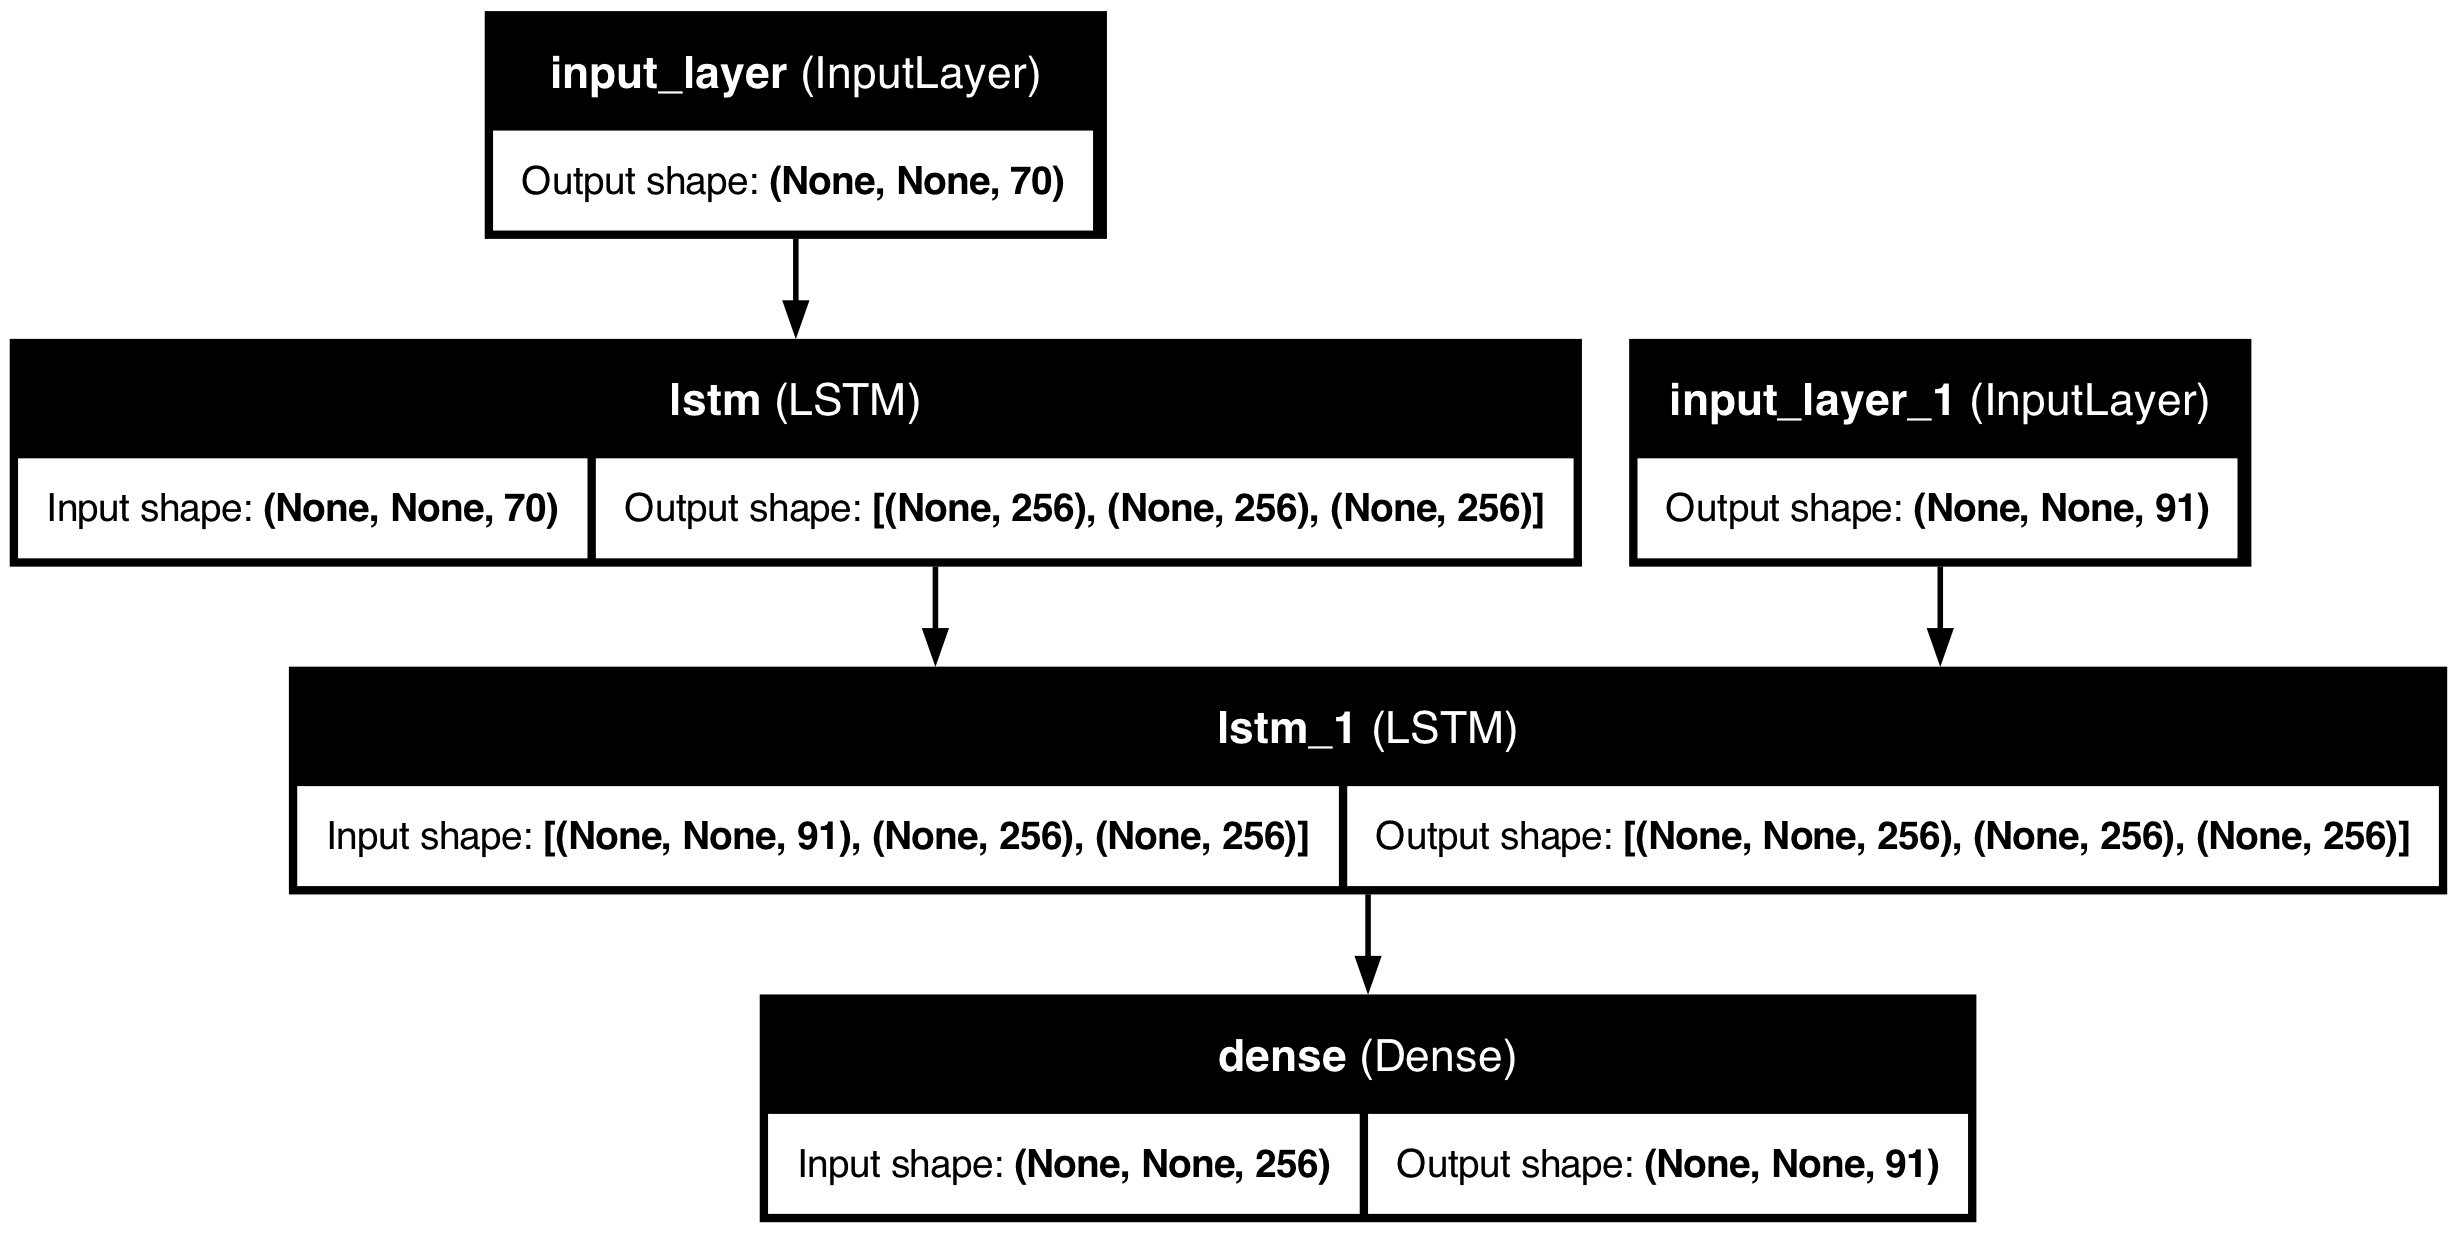

In [13]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [14]:
model.compile(
    optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"]
)
model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
)
# Save model
model.save("models/fra_eng/s2s_model.keras")

Epoch 1/100


2024-07-03 21:47:37.069515: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.7093 - loss: 1.4382 - val_accuracy: 0.7147 - val_loss: 1.0463
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.7509 - loss: 0.9372 - val_accuracy: 0.7271 - val_loss: 0.9634
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.7663 - loss: 0.8509 - val_accuracy: 0.7581 - val_loss: 0.8671
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.7859 - loss: 0.7686 - val_accuracy: 0.7705 - val_loss: 0.7921
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.8010 - loss: 0.6960 - val_accuracy: 0.7861 - val_loss: 0.7341
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.8112 - loss: 0.6526 - val_accuracy: 0.7926 - val_loss: 0.7113
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.8171 - loss: 0.6285 - val_accuracy: 0.7993 - val_loss: 0.6896
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.8237 - loss: 0.6076 - val_accuracy

In [24]:
# encoder_model = keras.Model(encoder_inputs, encoder_states)

# decoder_state_input_h = Input(shape=(latent_dim,))
# decoder_state_input_c = Input(shape=(latent_dim,))
# decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
# decoder_outputs, state_h, state_c = decoder_lstm(
#     decoder_inputs, initial_state=decoder_states_inputs)
# decoder_states = [state_h, state_c]
# decoder_outputs = decoder_dense(decoder_outputs)
# decoder_model = keras.Model(
#     [decoder_inputs] + decoder_states_inputs,
#     [decoder_outputs] + decoder_states)


model = keras.models.load_model("models/fra_eng/s2s_model.keras")

encoder_inputs = model.input[0]  # input_1
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output  # lstm_1
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(encoder_inputs, encoder_states)

decoder_inputs = model.input[1]  # input_2
decoder_state_input_h = keras.Input(shape=(latent_dim,))
decoder_state_input_c = keras.Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)

In [25]:
# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

In [26]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [27]:
for seq_index in range(20):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index : seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print("-")
    print("Input sentence:", input_texts[seq_index])
    print("Decoded sentence:", decoded_sentence)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
-
Input sentence: Go.
Decoded sentence: Je suis tout bonne.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 

In [1]:
import os
os.environ['MTL_DEVICE_OVERRIDE'] = 'CPUOnly'

import tensorflow as tf 
# tf.config.set_visible_devices([], 'GPU')


In [2]:
print(tf.__version__)
physical_devices = tf.config.list_physical_devices('GPU')
tf.print(physical_devices)  

2.16.2
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-07-06 10:22:24.575008: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-07-06 10:22:24.575032: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-07-06 10:22:24.575037: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-07-06 10:22:24.575315: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-06 10:22:24.575328: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:

import numpy as np
import keras
import os
from pathlib import Path

with tf.device('/cpu:0'):
    batch_size = 64  # Batch size for training.
    epochs = 50  # Number of epochs to train for.
    latent_dim = 256  # Latent dimensionality of the encoding space.
    num_samples = 10000  # Number of samples to train on.
    # Path to the data txt file on disk.
    data_path = 'fra-eng/fra.txt' #os.path.join(dirpath, "fra.txt")

    """
    ## Prepare the data
    """

    # Vectorize the data.
    input_texts = []
    target_texts = []
    input_characters = set()
    target_characters = set()
    with open(data_path, "r", encoding="utf-8") as f:
        lines = f.read().split("\n")
    for line in lines[: min(num_samples, len(lines) - 1)]:
        input_text, target_text, _ = line.split("\t")
        # We use "tab" as the "start sequence" character
        # for the targets, and "\n" as "end sequence" character.
        target_text = "\t" + target_text + "\n"
        input_texts.append(input_text)
        target_texts.append(target_text)
        for char in input_text:
            if char not in input_characters:
                input_characters.add(char)
        for char in target_text:
            if char not in target_characters:
                target_characters.add(char)

    input_characters = sorted(list(input_characters))
    target_characters = sorted(list(target_characters))
    num_encoder_tokens = len(input_characters)
    num_decoder_tokens = len(target_characters)
    max_encoder_seq_length = max([len(txt) for txt in input_texts])
    max_decoder_seq_length = max([len(txt) for txt in target_texts])

    print("Number of samples:", len(input_texts))
    print("Number of unique input tokens:", num_encoder_tokens)
    print("Number of unique output tokens:", num_decoder_tokens)
    print("Max sequence length for inputs:", max_encoder_seq_length)
    print("Max sequence length for outputs:", max_decoder_seq_length)

    input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
    target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

    encoder_input_data = np.zeros(
        (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
        dtype="float32",
    )
    decoder_input_data = np.zeros(
        (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
        dtype="float32",
    )
    decoder_target_data = np.zeros(
        (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
        dtype="float32",
    )

    for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
        for t, char in enumerate(input_text):
            encoder_input_data[i, t, input_token_index[char]] = 1.0
        encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0
        for t, char in enumerate(target_text):
            # decoder_target_data is ahead of decoder_input_data by one timestep
            decoder_input_data[i, t, target_token_index[char]] = 1.0
            if t > 0:
                # decoder_target_data will be ahead by one timestep
                # and will not include the start character.
                decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
        decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0
        decoder_target_data[i, t:, target_token_index[" "]] = 1.0

    """
    ## Build the model
    """

    # Define an input sequence and process it.
    encoder_inputs = keras.Input(shape=(None, num_encoder_tokens))
    encoder = keras.layers.LSTM(latent_dim, return_state=True)
    encoder_outputs, state_h, state_c = encoder(encoder_inputs)

    # We discard `encoder_outputs` and only keep the states.
    encoder_states = [state_h, state_c]

    # Set up the decoder, using `encoder_states` as initial state.
    decoder_inputs = keras.Input(shape=(None, num_decoder_tokens))

    # We set up our decoder to return full output sequences,
    # and to return internal states as well. We don't use the
    # return states in the training model, but we will use them in inference.
    decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
    decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax")
    decoder_outputs = decoder_dense(decoder_outputs)

    # Define the model that will turn
    # `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
    model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

    """
    ## Train the model
    """

    model.compile(
        optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"]
    )
    model.fit(
        [encoder_input_data, decoder_input_data],
        decoder_target_data,
        batch_size=batch_size,
        epochs=epochs,
        validation_split=0.2,
    )


Number of samples: 10000
Number of unique input tokens: 70
Number of unique output tokens: 91
Max sequence length for inputs: 14
Max sequence length for outputs: 59
Epoch 1/50


2024-07-06 10:22:39.608515: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.7091 - loss: 1.4712 - val_accuracy: 0.7141 - val_loss: 1.0408
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.7497 - loss: 0.9358 - val_accuracy: 0.7396 - val_loss: 0.9627
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.7682 - loss: 0.8420 - val_accuracy: 0.7586 - val_loss: 0.8510
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.7881 - loss: 0.7483 - val_accuracy: 0.7713 - val_loss: 0.7788
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.8032 - loss: 0.6865 - val_accuracy: 0.7794 - val_loss: 0.7356
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8115 - loss: 0.6486 - val_accuracy: 0.7999 - val_loss: 0.6947
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8186 - loss: 0.6233 - val_accuracy: 0.8020 - val_loss: 0.6758
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.8254 - loss: 0.6027 - val_accuracy: 0.809

In [2]:
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
with tf.device('/cpu:0'):
    import numpy as np
    import keras
    import os
    from pathlib import Path

    batch_size = 64  # Batch size for training.
    epochs = 100  # Number of epochs to train for.
    latent_dim = 256  # Latent dimensionality of the encoding space.
    num_samples = 10000  # Number of samples to train on.
    # Path to the data txt file on disk.
    data_path = 'fra-eng/fra.txt' #os.path.join(dirpath, "fra.txt")

    # Save model
    model.save("models/cpu_model/s2s_model.keras")

    """
    ## Run inference (sampling)

    1. encode input and retrieve initial decoder state
    2. run one step of decoder with this initial state
    and a "start of sequence" token as target.
    Output will be the next target token.
    3. Repeat with the current target token and current states
    """
    # Training the model on CPU

    # Define sampling models
    # Restore the model and construct the encoder and decoder.
    model = keras.models.load_model("models/cpu_model/s2s_model.keras")

    encoder_inputs = model.input[0]  # input_1
    encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output  # lstm_1
    encoder_states = [state_h_enc, state_c_enc]
    encoder_model = keras.Model(encoder_inputs, encoder_states)

    decoder_inputs = model.input[1]  # input_2
    decoder_state_input_h = keras.Input(shape=(latent_dim,))
    decoder_state_input_c = keras.Input(shape=(latent_dim,))
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    decoder_lstm = model.layers[3]
    decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
        decoder_inputs, initial_state=decoder_states_inputs
    )
    decoder_states = [state_h_dec, state_c_dec]
    decoder_dense = model.layers[4]
    decoder_outputs = decoder_dense(decoder_outputs)
    decoder_model = keras.Model(
        [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
    )

    # Reverse-lookup token index to decode sequences back to
    # something readable.
    reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
    reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())


    def decode_sequence(input_seq):
        # Encode the input as state vectors.
        states_value = encoder_model.predict(input_seq, verbose=0)

        # Generate empty target sequence of length 1.
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        # Populate the first character of target sequence with the start character.
        target_seq[0, 0, target_token_index["\t"]] = 1.0

        # Sampling loop for a batch of sequences
        # (to simplify, here we assume a batch of size 1).
        stop_condition = False
        decoded_sentence = ""
        while not stop_condition:
            output_tokens, h, c = decoder_model.predict(
                [target_seq] + states_value, verbose=0
            )

            # Sample a token
            sampled_token_index = np.argmax(output_tokens[0, -1, :])
            sampled_char = reverse_target_char_index[sampled_token_index]
            decoded_sentence += sampled_char

            # Exit condition: either hit max length
            # or find stop character.
            if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
                stop_condition = True

            # Update the target sequence (of length 1).
            target_seq = np.zeros((1, 1, num_decoder_tokens))
            target_seq[0, 0, sampled_token_index] = 1.0

            # Update states
            states_value = [h, c]
        return decoded_sentence


    """
    You can now generate decoded sentences as such:
    """

    for seq_index in range(20):
        # Take one sequence (part of the training set)
        # for trying out decoding.
        input_seq = encoder_input_data[seq_index : seq_index + 1]
        decoded_sentence = decode_sequence(input_seq)
        print("-")
        print("Input sentence:", input_texts[seq_index])
        print("Decoded sentence:", decoded_sentence)

2024-07-04 07:30:30.628570: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


-
Input sentence: Go.
Decoded sentence: Je suis sourde.

-
Input sentence: Go.
Decoded sentence: Je suis sourde.

-
Input sentence: Go.
Decoded sentence: Je suis sourde.

-
Input sentence: Go.
Decoded sentence: Je suis sourde.

-
Input sentence: Hi.
Decoded sentence: Je suis sourde.

-
Input sentence: Hi.
Decoded sentence: Je suis sourde.

-
Input sentence: Run!
Decoded sentence: Je suis sourde.

-
Input sentence: Run!
Decoded sentence: Je suis sourde.

-
Input sentence: Run!
Decoded sentence: Je suis sourde.

-
Input sentence: Run!
Decoded sentence: Je suis sourde.

-
Input sentence: Run!
Decoded sentence: Je suis sourde.

-
Input sentence: Run!
Decoded sentence: Je suis sourde.

-
Input sentence: Run!
Decoded sentence: Je suis sourde.

-
Input sentence: Run!
Decoded sentence: Je suis sourde.

-
Input sentence: Run.
Decoded sentence: Je suis sourde.

-
Input sentence: Run.
Decoded sentence: Je suis sourde.

-
Input sentence: Run.
Decoded sentence: Je suis sourde.

-
Input sentence: Ru

In [1]:
import tensorflow as tf

embedding_layer = tf.keras.layers.Embedding(input_dim=10000, output_dim=64)

# Example input: batch of 2 sequences, each of length 5
input_data = tf.constant([[1, 2, 3, 4, 5], [6, 7, 8, 9, 10]])

output_data = embedding_layer(input_data)
print(output_data.shape)


(2, 5, 64)


2024-07-06 20:33:34.113308: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-07-06 20:33:34.113332: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-07-06 20:33:34.113337: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-07-06 20:33:34.113627: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-06 20:33:34.113650: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [2]:
output_data

<tf.Tensor: shape=(2, 5, 64), dtype=float32, numpy=
array([[[ 2.12596096e-02,  4.26974557e-02,  1.75273754e-02,
          3.22216265e-02, -1.93833113e-02,  1.77936293e-02,
          2.76677050e-02, -3.07983644e-02, -1.08447075e-02,
          4.61323187e-03,  2.96594948e-03, -2.70918738e-02,
         -1.90854073e-02,  6.15785271e-03, -1.42076388e-02,
          3.25365402e-02,  1.88457482e-02, -2.41644736e-02,
          3.33267190e-02, -4.21856530e-02,  2.52724029e-02,
         -4.20247205e-02,  3.72748040e-02, -3.55034582e-02,
         -4.69112992e-02, -2.82912850e-02,  2.32740976e-02,
         -3.92366052e-02,  3.14850472e-02, -2.26473566e-02,
         -2.13407166e-02, -3.35093588e-03,  2.77703889e-02,
         -4.11088690e-02, -3.67464907e-02,  2.32242383e-02,
         -3.28939445e-02,  1.40447728e-02,  3.76882441e-02,
         -4.53414433e-02,  1.45615228e-02, -1.24060884e-02,
         -4.24213521e-02,  3.26221697e-02,  4.08714674e-02,
         -2.34591365e-02,  3.28992717e-02, -3.87